# Attempt to describe strains of a given gene

This is for gene 868 in BACT1, which has three "levels" of mutation frequencies -- around 2%, 5%, and 7%. The idea is to transform each read spanning this gene (length $k$) into a binary $k$-dimensional vector (where each element represents "does this read have a mutation at this position in the gene?"), and then to perform clustering on these vectors.

In [1]:
%run "Header.ipynb"
import pickle
import pysam
import skbio
import pileup
import numpy as np
from parse_sco import parse_sco
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecatio

In [2]:
seq2pos2pileup = pileup.load()

In [148]:
RAND_STATE = 333

## Load info about this gene and its sequence

In [149]:
bact1_genes = parse_sco("../seqs/genes/edge_1671.sco")
gene_data = bact1_genes.loc[868]
assert gene_data.LeftEnd == 1041656
assert gene_data.RightEnd == 1042084
assert gene_data.Length == 429
assert gene_data.Strand == "+"

In [150]:
fasta = skbio.DNA.read("../seqs/edge_1671.fasta")
gene_seq = fasta[gene_data.LeftEnd - 1: gene_data.RightEnd]
assert len(gene_seq) == gene_data.Length
print(gene_seq)

TTGGCTAGGGTTACTAGGTTAGCTAGGTTAGATAGGGTTACTAGGTTAGATAGGGTTACTAGGTTGGCTAGGTTAGCTAGGTTGGCTAGGTTGGCTAGGTTGGCTAGGGTTACTAGGTTAGCTAGGGTTACTAGGTTAGCTAGGGTTACTAGGTTAGCTATGTTAGCTAGGATAGCTAGGATAGCTAGGATAGCTAGGGTTACTAGGATAGCTAGGTTAGCTAGGATAGCTAGGGTTACTAGGATAGCTAGGTTAGCTAGGTTGGCTAGGTTAGCTAGGGTTACTAGGGTTACTAGGGTTACTAGGATAGCTAGGTTAGCTAGGGTTACTAGGGTTACTAGGGTTACTAGGATAGCTAGGTTAGCTAGGTTGGCTAGGGTTTTACTTAGTTATCTTAGCTATCTTAGTTATCTTAGTTATCTTAGTTAA


### Sanity check: in all positions here, the reference nucleotide is also the consensus nucleotide

This isn't a _requirement_ or anything, but it makes life easier when programming this.

In [151]:
for pos in range(gene_data.LeftEnd, gene_data.RightEnd + 1):
    assert pileup.is_reasonable(seq2pos2pileup["edge_1671"][pos])

## Find spanning reads and compute binary vectors

In [152]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

def aln_spans_gene(aln):
    # aln is a linear alignment (pysam AlignedSegment object).
    # We use the term "aln" rather than "read" since a read can have multiple linear alignments, e.g. due
    # to supplementary alignnments (we've already removed secondary alignments).
    #
    # reference_start is 0-indexed, and reference_end is 0-indexed but points to 1 past the end (so we can
    # use it as is). This check verifies that this read "spans" this gene. It DOESN'T verify that this
    # read doesn't have any indels within this region, but it should at least mean that this read at least
    # spans the entire gene in some way. Which is good enough for us.
    return (aln.reference_start + 1) <= gene_data.LeftEnd and aln.reference_end >= gene_data.RightEnd

def pos_in_gene(pos):
    # Is a given position located within the boundaries of the gene?
    # pos is 0-indexed, i.e. returned from pysam
    p1 = pos + 1
    return (p1 >= gene_data.LeftEnd) and (p1 <= gene_data.RightEnd)

### Sanity check: all spanning alignments are from unique reads

Again, this would be possible to handle, but being able to make the assumption that each linear alignment is unique is really useful for keeping the code simple.

In [153]:
read_names_spanning_gene = set()

# double-check real quick that all alignments spanning this gene are from unique reads, so we
# don't have to worry about merging supplementary alignments
for aln in bf.fetch("edge_1671", gene_data.LeftEnd - 1, gene_data.RightEnd):
    if aln_spans_gene(aln):
        if aln.query_name in read_names_spanning_gene:
            raise ValueError("uh oh marcus needs to drink more coffee and rewrite this notebook")
        read_names_spanning_gene.add(aln.query_name)
    
print(f"There were {len(read_names_spanning_gene):,} unique reads spanning this gene.")
print("Thankfully, no two linear alignments spanning this gene came from the same read.")

There were 1,273 unique reads spanning this gene.
Thankfully, no two linear alignments spanning this gene came from the same read.


In [154]:
class ReadVector:
    def __init__(self, name, vector):
        self.name = name
        self.vector = vector
    
    def __repr__(self):
        return f"ReadVector from read {self.name} with {sum(self.vector):,} mismatches"

In [155]:
vecs = []
ai = 0
for aln in bf.fetch("edge_1671", gene_data.LeftEnd - 1, gene_data.RightEnd):
    if aln_spans_gene(aln):
        if ai % 10 == 0:
            print(f"Seen {ai:,} spanning alignments.")
        vec = [0] * gene_data.Length
        aln_seq = aln.query_sequence
        for pair in aln.get_aligned_pairs():
            if pair[1] is not None and pos_in_gene(pair[1]):
                
                # Figure out where pair[1] is, in relation to the gene's coordinates.
                # gene_relpos will be an integer in the range [0, 428], where 0 corresponds to the first
                # position of the gene, 1 is the second position of the gene, ..., and 428 is the 429-th
                # position of the gene.
                gene_relpos = pair[1] + 1 - gene_data.LeftEnd
                
                # pair[0] points to a position on a read sequence. Both skbio and pysam are 0-indexed, so
                # this is easy
                if pair[0] is None:
                    # There's a deletion / skip at this position in the read; mark this as a mutation.
                    vec[gene_relpos] = 1
                else:
                    read_nt_at_pos = aln_seq[pair[0]]
                    # pair[1] points to a position on edge_1671's sequence
                    ref_nt_at_pos = fasta[pair[1]]


                    # Just to be extra safe, make sure we're handling this ok
                    assert str(ref_nt_at_pos) == str(gene_seq[gene_relpos])
                    # print(f"Position {pair[1] + 1:,} on ref is {gene_relpos + 1:,} on gene.")

                    # Finally, the point of this notebook: figure out of this read has a mismatch at this position
                    # NOTE: for some reason, comparing skbio sliced out DNA objects with equality seems to result
                    # in a bunch of false positives. Converting to strings fixes this (???)
                    if str(read_nt_at_pos) != str(ref_nt_at_pos):
                        vec[gene_relpos] = 1
        ai += 1
        vecs.append(ReadVector(aln.query_name, vec))

Seen 0 spanning alignments.
Seen 10 spanning alignments.
Seen 20 spanning alignments.
Seen 30 spanning alignments.
Seen 40 spanning alignments.
Seen 50 spanning alignments.
Seen 60 spanning alignments.
Seen 70 spanning alignments.
Seen 80 spanning alignments.
Seen 90 spanning alignments.
Seen 100 spanning alignments.
Seen 110 spanning alignments.
Seen 120 spanning alignments.
Seen 130 spanning alignments.
Seen 140 spanning alignments.
Seen 150 spanning alignments.
Seen 160 spanning alignments.
Seen 170 spanning alignments.
Seen 180 spanning alignments.
Seen 190 spanning alignments.
Seen 200 spanning alignments.
Seen 210 spanning alignments.
Seen 220 spanning alignments.
Seen 230 spanning alignments.
Seen 240 spanning alignments.
Seen 250 spanning alignments.
Seen 260 spanning alignments.
Seen 270 spanning alignments.
Seen 280 spanning alignments.
Seen 290 spanning alignments.
Seen 300 spanning alignments.
Seen 310 spanning alignments.
Seen 320 spanning alignments.
Seen 330 spanning ali

In [156]:
with open("misc-output/bact1-gene-868-vecs.pickle", "wb") as pf:
    pf.write(pickle.dumps(vecs))

In [157]:
with open("misc-output/bact1-gene-868-vecs.pickle", "rb") as pf:
    vecs = pickle.load(pf)

## Perform clustering on these vectors

### How many "disagreements" are at each position in this gene?

Our definition of "disagreements" depends on how the code above works -- originally this only considered mismatches, but now deletions/skips are counted. This gene has a lot of deletions!

In [158]:
num_muts = [0] * 429
for v in vecs:
    for p, is_mut in enumerate(v.vector):
        num_muts[p] += is_mut
print(num_muts)

num_positions_with_less_than_2_mismatches = 0
for p in num_muts:
    if p < 2:
        num_positions_with_less_than_2_mismatches += 1
print(f"{num_positions_with_less_than_2_mismatches:} / 429 positions have 0 or 1 mismatches.")

[25, 22, 87, 22, 23, 23, 23, 26, 24, 49, 26, 28, 28, 22, 22, 23, 24, 21, 28, 22, 21, 21, 22, 21, 21, 22, 24, 88, 24, 24, 24, 108, 25, 25, 27, 47, 106, 48, 105, 107, 47, 46, 46, 49, 103, 106, 103, 104, 83, 87, 82, 84, 86, 82, 106, 107, 105, 107, 105, 83, 83, 86, 84, 89, 83, 88, 83, 85, 84, 84, 85, 84, 88, 84, 85, 85, 84, 84, 84, 86, 84, 91, 85, 109, 84, 83, 83, 83, 84, 84, 92, 84, 88, 85, 84, 85, 84, 85, 83, 91, 83, 93, 85, 83, 84, 85, 111, 84, 105, 88, 106, 107, 83, 83, 84, 24, 24, 29, 23, 26, 44, 24, 24, 24, 29, 24, 47, 26, 46, 46, 24, 23, 23, 26, 24, 49, 23, 85, 24, 23, 23, 23, 27, 24, 28, 24, 27, 27, 24, 25, 24, 25, 23, 85, 25, 25, 23, 24, 25, 25, 110, 27, 27, 24, 47, 24, 24, 24, 24, 28, 25, 109, 26, 47, 27, 26, 26, 25, 25, 24, 107, 24, 44, 24, 23, 24, 23, 26, 23, 45, 23, 24, 23, 43, 43, 44, 46, 43, 45, 43, 44, 46, 44, 44, 45, 46, 44, 108, 44, 45, 46, 43, 43, 44, 44, 43, 46, 43, 43, 43, 44, 43, 43, 46, 43, 106, 45, 43, 43, 44, 44, 44, 47, 44, 46, 47, 45, 46, 26, 24, 24, 32, 25, 47, 

### Optional: Reduce the vectors' dimensionality

Rather than a separate dimension for each position, we only include dimensions for $p$-mutated positions (naively defining "$p$-mutated" by comparing freq(pos) to 0.5%). I guess you could think of this step as analogous to trimming unimportant features from a dataset.

**Update:** So, it turns out that doing this barely changes anything (the results are almost exactly the same: the cluster assignments at $k = 3$ don't change, and the PCA looks identical as far as I can tell). Since it's easier to explain, I'll stick with 429 dimensions, but feel free to change `USE_ALL_POSITIONS` to `False` below (and if you want to try out even more stuff, to change `p` below to something different like `1.5%`) and see how things change.

**Update 2:** I typed the above paragraph out when we weren't considering deletions/skips as disagreements (`1`s in the vectors). I think this does change things a bit (at least for the PCA) when using the more liberal deletion-inclusive definition of disagreement, since the features (positions) now have a lot more variation. In any case, think we'll stick with all dimensions for now.

In [205]:
USE_ALL_POSITIONS = True

all_vecs = []

if not USE_ALL_POSITIONS:
    p = 0.5
    p_pct = p / 100

    # 0-indexed locations of mutated positions in each of the 429-length vectors
    mutated_positions = []
    for pos in range(gene_data.LeftEnd, gene_data.RightEnd + 1):
        if pileup.naively_call_mutation(seq2pos2pileup["edge_1671"][pos], p_pct):
            mutated_positions.append(pos - gene_data.LeftEnd)

    ndims = len(mutated_positions)
    print(
        f"{ndims} positions are p-mutated at p = {p:.2f}%.\n"
        f"Reducing the binary vectors to just {ndims} dimensions."
    )
    for rv in vecs:
        new_vec = []
        for mp in mutated_positions:
            new_vec.append(rv.vector[mp])
        all_vecs.append(new_vec)
        
else:
    ndims = gene_data.Length
    print(f"Using all {ndims} dimensions of the binary vectors.")
    # Use all 429 dimensions
    all_vecs = [rv.vector for rv in vecs]

Using all 429 dimensions of the binary vectors.


### Construct a matrix of the binary vectors

In [206]:
# Convert the vector objects into a matrix we can perform PCA on
mat = np.array(all_vecs)

# The argument to pca.fit(), or kmeans.fit(), needs to be a numpy array-like with shape (# samples, # features)
# So our matrix should have shape (1273, ndims) indicating that we have 1,273 "samples" (spanning reads)
# and ndims "features" (either 429 if USE_ALL_POSITIONS is true, or a smaller number if USE_ALL_POSITIONS is false
# and we're only using a subset of mutated positions -- for example the 86 p = 0.5%-mutated positions)
mat.shape

(1273, 429)

### Use the elbow method to determine what the optimal value of $k$ (for $k$-means clustering) is

We use the "inertia" measurement as our measure of how good a clustering run performed. From the [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):

 > Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided.
 
We don't provide any sample weights (all reads are equally important -- I guess we could try some stuff with quality scores to add weights, but let's keep it simple for now), so this is really just the sum of squared distances.
 
Use of inertia in this context based on [this blog post](https://www.analyticsvidhya.com/blog/2021/01/in-depth-intuition-of-k-means-clustering-algorithm-in-machine-learning/) and supported by [this StackOverflow answer](https://stackoverflow.com/a/48212561).

In [207]:
k_values = list(range(1, 21))

In [208]:
inertias = []
kmeans_results = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=RAND_STATE)
    kmeans.fit(mat)
    kmeans_results.append(kmeans)
    inertias.append(kmeans.inertia_)
    print(f"Inertia of k = {k} is {kmeans.inertia_:,.2f}")

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 1 is 18,991.67
Inertia of k = 2 is 7,696.94


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 3 is 3,883.70
Inertia of k = 4 is 1,202.03


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 5 is 935.11
Inertia of k = 6 is 836.51


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:400: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecate

Inertia of k = 7 is 727.89
Inertia of k = 8 is 655.39


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 9 is 591.76
Inertia of k = 10 is 579.07


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:400: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_iter=max_iter, verbose=verbose)
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecate

Inertia of k = 11 is 502.57
Inertia of k = 12 is 482.44


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 13 is 446.25


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 14 is 432.04


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 15 is 420.14


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 16 is 407.73


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 17 is 395.08


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 18 is 392.40


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

Inertia of k = 19 is 378.42
Inertia of k = 20 is 365.54


/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mfedarko/miniconda3/envs/mut-analyses/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/

In [209]:
# Using the "elbow method", we select k = 4 as the optimal number of clusters.
optimal_k = 4

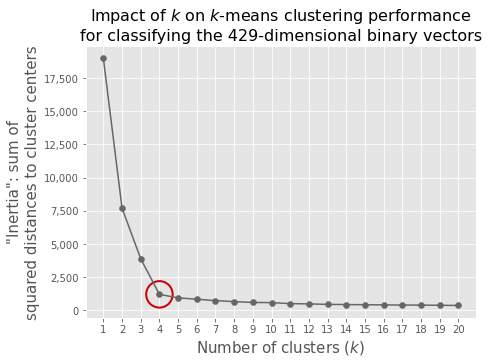

In [210]:
fig, ax = pyplot.subplots(1, 1)
ax.plot(k_values, inertias, color="#666666")
ax.scatter(k_values, inertias, color="#666666")
ax.scatter(optimal_k, inertias[optimal_k - 1], 700, color="#cc0000", facecolor="none", lw=2)
ax.set_xticks(k_values)
use_thousands_sep(ax.yaxis)
ax.set_title(
    f"Impact of $k$ on $k$-means clustering performance\nfor classifying the {ndims:,}-dimensional binary vectors",
    fontsize=16
)
ax.set_xlabel("Number of clusters ($k$)", fontsize=15)
ax.set_ylabel('"Inertia": sum of\nsquared distances to cluster centers', fontsize=15)
fig.set_size_inches(7, 5)
fig.savefig("figs/edge_1671_gene868_elbow.png")

In [211]:
# These are the "Dark2" colors from https://colorbrewer2.org/. Should be relatively colorblind-friendly.
cluster2color = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e"]
vec2color = [cluster2color[v] for v in kmeans_results[optimal_k - 1].labels_]

In [212]:
cluster_freqs = [0] * optimal_k
for lbl in kmeans_results[optimal_k - 1].labels_:
    cluster_freqs[lbl] += 1
    
print(f"Cluster frequencies: {cluster_freqs}")

Cluster frequencies: [1166, 22, 62, 23]


### Perform PCA on the matrix of binary vectors, then plot this in two dimensions (coloring points by their assigned $k = 3$-means cluster)

In [213]:
# We could perform PCA in more dimensions, but we're going to include this
# in a paper so let's just use two of 'em
pca = PCA(n_components=2, random_state=RAND_STATE)
mat_trans = pca.fit_transform(mat)

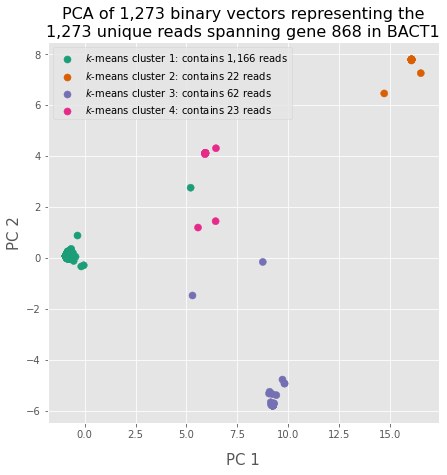

In [220]:
fig, ax = pyplot.subplots(1, 1)
ax.set_title(
    f"PCA of {len(vecs):,} binary vectors representing the\n"
    f"{len(vecs):,} unique reads spanning gene {gene_data.name} in {seq2name['edge_1671']}",
    fontsize=16
)
ax.set_xlabel("PC 1", fontsize=15, labelpad=13)
ax.set_ylabel("PC 2", fontsize=15)

pointsize = 50
seen_clusters = set()
x = []
y = []
c = []
# Plot first three points of each of the 3 clusters specially, so we can give them fancy labels
for i, v in enumerate(mat_trans):
    
    cluster = kmeans_results[optimal_k - 1].labels_[i]
    
    if cluster not in seen_clusters:
        ax.scatter(
            v[0], v[1], color=vec2color[i], s=pointsize,
            label=f"$k$-means cluster {cluster + 1}: contains {cluster_freqs[cluster]:,} reads"
        )
        seen_clusters.add(cluster)
    else:
        x.append(v[0])
        y.append(v[1])
        c.append(vec2color[i])
        
# Plot the remaining 1,273 - 3 = 1,270 points all at once because plotting them individually is super slow
ax.scatter(x, y, color=c, s=pointsize)

# Using ax.legend() instead of fig.legend() allows us to let the axis object figure out the best legend
# location automatically, which is nice. I was previously using fig.legend() and manually positioning the
# legend, and then the PNG export's legend was located in a different place for some reason, and ...
# But this way is easier.
ax.legend(fontsize=10)
fig.set_size_inches(7, 7)
fig.savefig("figs/edge_1671_gene868_pca.png")